In [66]:
import joblib
import json
import matplotlib.pyplot as plt
import seaborn as sns
from mave_calibration.skew_normal import density_utils
from main import load_data,singleFit,plot
import numpy as np
from scipy.stats import skewnorm
from scipy.stats import mannwhitneyu, ttest_ind
from scipy.special import rel_entr
from mave_calibration.skew_normal.density_utils import joint_densities
import scipy.stats as sp
from sklearn.metrics import roc_auc_score
from tqdm.notebook import trange,tqdm
from joblib import Parallel, delayed

In [46]:
dataset_id = "urn_mavedb_00000068-a-1"
observations = joblib.load(f"/mnt/d/mave_calibration/data/{dataset_id}/observations.pkl")

In [47]:
def makeData(sample_names):
    NSamples = len(sample_names)
    X = np.zeros((0,))
    S = np.zeros((0,NSamples),dtype=bool)
    for sample_name in sample_names:
        sample = observations[sample_name]
        X = np.concatenate((X, sample))
        si = np.zeros((len(sample), NSamples),dtype=bool)
        si[:,sample_names.index(sample_name)] = True
        S = np.concatenate((S, si))
    return X, S

In [58]:
sample_names = ['pathogenic_missense','synonymous','gnomad']
X,S = makeData(sample_names)


In [59]:
fit = singleFit(X,S)

  0%|          | 0/10000 [00:00<?, ?it/s]

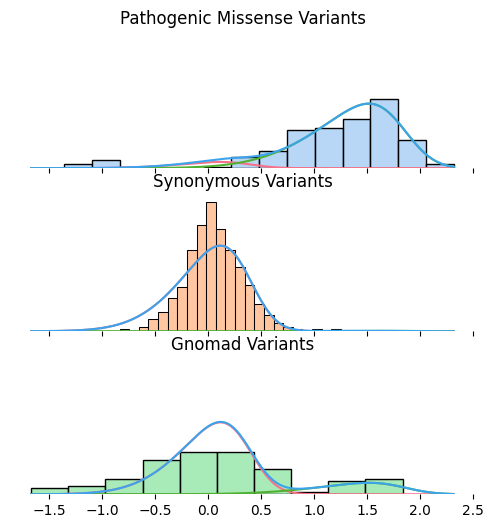

In [60]:
_ = plot(X,S,sample_names,fit[1],fit[0],figsize=(6,6),sharex=True,sharey=True)

In [61]:
def draw_sample(params,weights,N=1):
    samples = []
    for i in range(N):
        k = np.random.binomial(1,weights[1])
        samples.append(sp.skewnorm.rvs(*params[k]))
    return np.array(samples)

def auc_from_samples(x1,x2):
    return roc_auc_score(np.concatenate((np.zeros(x1.shape[0]),np.ones(x2.shape[0]))),np.concatenate((x1,x2)))

def bootstrap(x):
    return np.random.choice(x, size=x.shape[0], replace=True)

def iteration(sample_num):
    return auc_from_samples(bootstrap(X[S[:,sample_num]]),
                          draw_sample(fit[0],fit[1][sample_num],
                                      N=S[:,sample_num].sum()))

def null_iteration(sample_num):
    return auc_from_samples(bootstrap(X[S[:,sample_num]]),
                          bootstrap(X[S[:,sample_num]]))

In [64]:
aucs = [Paralleal(n_jobs=-1)(delayed(iteration)(sample_num) for _ in range(1000)) for sample_num in trange(S.shape[1])]

null_aucs = [Parallel(n_jobs=-1)(delayed(null_iteration)(sample_num) for _ in range(1000)) for sample_num in trange(S.shape[1])]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

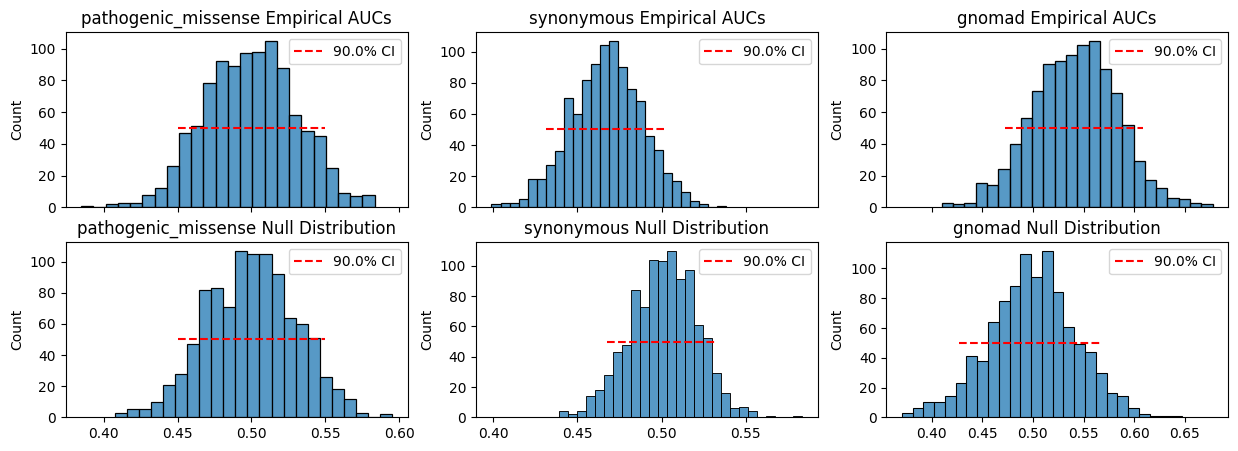

In [65]:
CONFIDENCE_LEVEL = .1
qmin,qmax = 100 * CONFIDENCE_LEVEL / 2, 100 * (1 - CONFIDENCE_LEVEL/2)
fig,ax = plt.subplots(2,S.shape[1],figsize=(5 * S.shape[1],5),sharex='col')
for i in range(S.shape[1]):
    sns.histplot(aucs[i],ax=ax[0,i])
    a = np.array(aucs[i])
    ax[0,i].set_title(f"{sample_names[i]} Empirical AUCs")
    CI = np.percentile(a,[qmin,qmax])
    ax[0,i].hlines(50,CI[0],CI[1],color='r',linestyle='--',label=f"{100 * (1 - CONFIDENCE_LEVEL)}% CI")
    ax[0,i].legend()
    sns.histplot(null_aucs[i],ax=ax[1,i])
    a = np.array(null_aucs[i])
    CI = np.percentile(a,[qmin,qmax])
    ax[1,i].hlines(50,CI[0],CI[1],color='r',linestyle='--',label=f"{100 * (1 - CONFIDENCE_LEVEL)}% CI")
    ax[1,i].legend()
    ax[1,i].set_title(f"{sample_names[i]} Null Distribution")